In [ ]:
#| default_exp netana_ex04

In [ ]:
#| export
from nbdev.showdoc import *
from typing import Tuple

In [ ]:
#| export
from graph_tool.all import *
import graph_tool.inference
import itertools

# Assignment 4
> Solutions by Felix Kalchschmid


## Exercise 1
(2 points)

* Execute the Kernighan-Lin partitioning variant as given in the lecture in
the following network, where the starting partitions are given by the colours.
* Try to find a starting partition that changes the outcome. Either provide it with the changed outcome or try to explain why it is not possible.


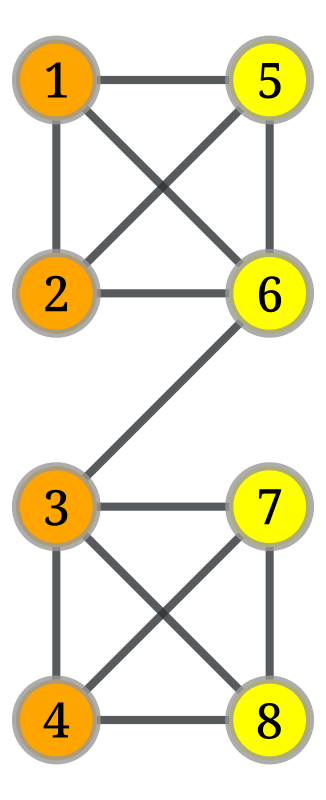

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2083517f80,>

In [ ]:
#| echo: false
# Create graph
g = Graph(directed=False)
vlist = [g.add_vertex() for _ in range(8)]

# Edges (1-based to 0-based)
edges = [
    (1, 2), (1, 5), (1, 6), (2, 5), (2, 6),
    (3, 4), (3, 6), (3, 7), (3, 8),
    (4, 7), (4, 8), (5, 6), (7, 8)
]
g.add_edge_list([(u - 1, v - 1) for u, v in edges])

# Partitions after swapping (3 <-> 5)
A = {1, 2, 3, 4}
B = {5, 6, 7, 8}

# Vertex positions (manual layout)
pos = g.new_vertex_property("vector<double>")
positions = {
    0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3),
    4: (1, 0), 5: (1, 1), 6: (1, 2), 7: (1, 3),
}
for i, p in positions.items():
    pos[g.vertex(i)] = p

# Color by partition
fill_color = g.new_vertex_property("string")
for i in range(1, 9):
    fill_color[g.vertex(i - 1)] = "orange" if i in A else "yellow"

# Labels (1-based)
labels = g.new_vertex_property("int")
for i in range(8):
    labels[g.vertex(i)] = i + 1

# Draw
graph_draw(g, pos=pos, vertex_fill_color=fill_color,
           vertex_text=labels, output_size=(400, 400))

**To provide a solution to the exercise:**
Provide the D values for each step and the maximum gain for the selection of the swap. Indicate the change of partitions from the swaps (preferred: visually), including the selected nodes, as well as the fixed nodes in each step. List the cut costs for each step and the selected prefix of swaps, too. Provide a starting partition or argument.

**Given:** A graph with $2n$ nodes where each node has the same weight.\
**Goal:** A partition of the graph into two disjoint subsets $A$ and $B$ with minimum cut cost and $|A| = |B| = n$.\
The example has $n=4$

We define the reduction in cost for when two elements $a\in A$ and $b\in B$ are interchanged as $g_{ab} = D_a + D_b - 2c_{ab}$
and the cost reduction for moving $a$: $D_a = k_a^{ext} - k_a^{int}$.


**For the start we can define:**\
Cut cost: $9$\
Not fixed:  $1, 2, 3, 4, 5, 6, 7, 8$\
Benefit $D_v$ of each node:

In [ ]:
d = {
    1: 1,
    2: 1,
    3: 2,
    4: 1,
    5: 1,
    6: 2,
    7: 1,
    8: 1,
}

Now we need to compute the gains for all possible swaps and look for the maximum gain swap:

For that we also define  $c_{ij}$ as the cost  of links between $i$ and $j$ (double counted in the $D$s but don't provide gain)


In [ ]:
# Connection checker (returns 1 if connected, else 0)
def c(i, j):
    vi, vj = g.vertex(i - 1), g.vertex(j - 1)  # 1-based to 0-based for graph_tool
    return 1 if g.edge(vi, vj) or g.edge(vj, vi) else 0

def gain(i, j, d):
    return d[i] + d[j] - 2 * c(i, j)

def compute_gains(d):
    g = {}
    for i in range(1, 5):
        for j in range(5, 9):
            g[(i, j)] = gain(i, j, d)
    return g

In [ ]:
gains = compute_gains(d)
gains

{(1, 5): 0,
 (1, 6): 1,
 (1, 7): 2,
 (1, 8): 2,
 (2, 5): 0,
 (2, 6): 1,
 (2, 7): 2,
 (2, 8): 2,
 (3, 5): 3,
 (3, 6): 2,
 (3, 7): 1,
 (3, 8): 1,
 (4, 5): 2,
 (4, 6): 3,
 (4, 7): 0,
 (4, 8): 0}

In [ ]:
def compute_max_gain(gains):
    mx_gain = min(gains.values())
    mx_gain_index = Tuple
    for i in range(1, 5):
        for j in range(5, 9):
            if gains[(i,j)]> mx_gain:
                mx_gain = gains[(i,j)]
                mx_gain_index = (i, j)
    print (f"maximum gain: {mx_gain}, nodes to swap: {mx_gain_index}")

    return mx_gain, mx_gain_index

In [ ]:
max_gain, max_gain_index = compute_max_gain(gains)

maximum gain: 3, nodes to swap: (3, 5)


Now we choose nodes (3, 5) for swapping and fix them, though we could also swap (4, 6).

In [ ]:
def swap_nodes(i, j):
    # Swap nodes 3 and 5
    A.remove(i)
    B.remove(j)
    A.add(j)
    B.add(i)

    # Update vertex colors
    for i in range(1, 9):
        if i in A:
            fill_color[g.vertex(i - 1)] = "orange"
        else:
            fill_color[g.vertex(i - 1)] = "yellow"

    # Draw updated graph
    graph_draw(
        g, pos=pos, vertex_fill_color=fill_color,
        vertex_text=labels, output_size=(400, 400)
    )

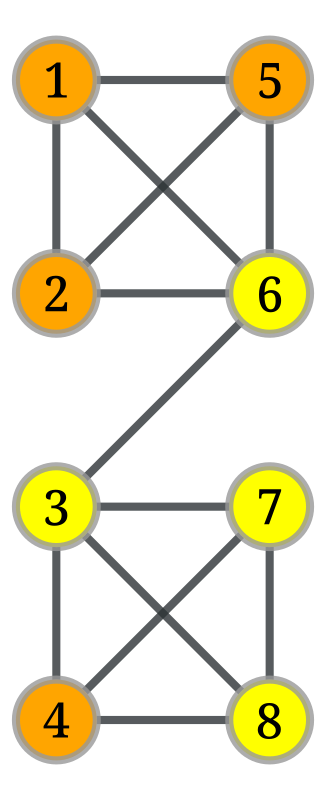

In [ ]:
swap_nodes(max_gain_index[0], max_gain_index[1])


Cut cost: $6$\
Not fixed:  $1, 2, 4, 6, 7, 8$\
New $D'_v$-values of each node is computed as
$$D'_x = D_x + 2c_{xa} - 2c_{xb}, \forall x \in A - \{a\}$$
$$D'_y = D_y + 2c_{yb} - 2c_{ya}, \forall y \in B - \{b\}$$

In [ ]:
def new_d(x, a, b):
    return d[x] + 2*c(x, a) - 2*c(x, b)

In [ ]:
d_new = {
    1: new_d(1, 3, 5),
    2: new_d(2, 3, 5),
    3: -1000,
    4: new_d(4, 3, 5),
    5: -1000,
    6: new_d(6, 5, 3),
    7: new_d(7, 5, 3),
    8: new_d(8, 5, 3),
}
d_new

{1: -1, 2: -1, 3: -1000, 4: 3, 5: -1000, 6: 2, 7: -1, 8: -1}

In [ ]:
gains = compute_gains(d_new)
gains

{(1, 5): -1003,
 (1, 6): -1,
 (1, 7): -2,
 (1, 8): -2,
 (2, 5): -1003,
 (2, 6): -1,
 (2, 7): -2,
 (2, 8): -2,
 (3, 5): -2000,
 (3, 6): -1000,
 (3, 7): -1003,
 (3, 8): -1003,
 (4, 5): -997,
 (4, 6): 5,
 (4, 7): 0,
 (4, 8): 0}

In [ ]:
max_gain, max_gain_index = compute_max_gain(gains)

maximum gain: 5, nodes to swap: (4, 6)


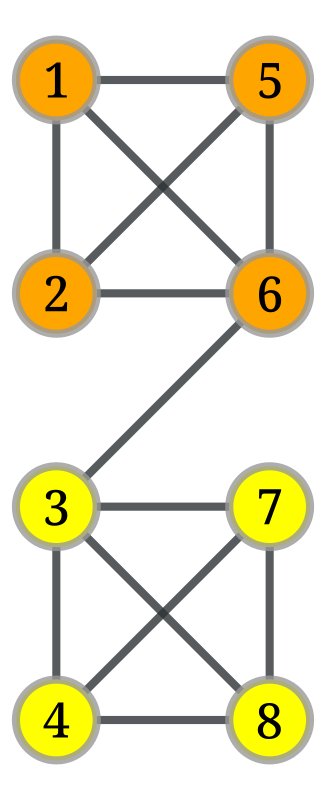

In [ ]:
swap_nodes(max_gain_index[0], max_gain_index[1])

In [ ]:
d_new_new = {
    1: new_d(1, 4, 6),
    2: new_d(2, 4, 6),
    3: -1000,
    4: -1000,
    5: -1000,
    6: -1000,
    7: new_d(7, 6, 4),
    8: new_d(8, 6, 4),
}
print(d_new_new)
gains = compute_gains(d_new_new)
print(gains)
max_gain, max_gain_index = compute_max_gain(gains)

{1: -1, 2: -1, 3: -1000, 4: -1000, 5: -1000, 6: -1000, 7: -1, 8: -1}
{(1, 5): -1003, (1, 6): -1003, (1, 7): -2, (1, 8): -2, (2, 5): -1003, (2, 6): -1003, (2, 7): -2, (2, 8): -2, (3, 5): -2000, (3, 6): -2002, (3, 7): -1003, (3, 8): -1003, (4, 5): -2000, (4, 6): -2000, (4, 7): -1003, (4, 8): -1003}
maximum gain: -2, nodes to swap: (1, 7)


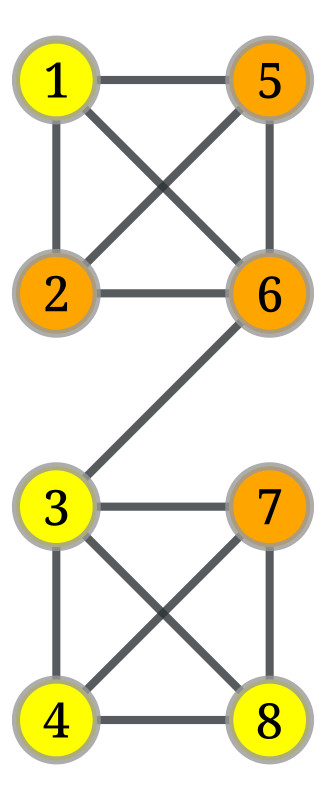

In [ ]:
swap_nodes(max_gain_index[0], max_gain_index[1])


In [ ]:
d_new_new_new = {
    1: -1000,
    2: new_d(2, 4, 6),
    3: -1000,
    4: -1000,
    5: -1000,
    6: -1000,
    7: -1000,
    8: new_d(8, 6, 4),
}
print(d_new_new_new)
gains = compute_gains(d_new_new_new)
print(gains)
max_gain, max_gain_index = compute_max_gain(gains)

{1: -1000, 2: -1, 3: -1000, 4: -1000, 5: -1000, 6: -1000, 7: -1000, 8: -1}
{(1, 5): -2002, (1, 6): -2002, (1, 7): -2000, (1, 8): -1001, (2, 5): -1003, (2, 6): -1003, (2, 7): -1001, (2, 8): -2, (3, 5): -2000, (3, 6): -2002, (3, 7): -2002, (3, 8): -1003, (4, 5): -2000, (4, 6): -2000, (4, 7): -2002, (4, 8): -1003}
maximum gain: -2, nodes to swap: (2, 8)


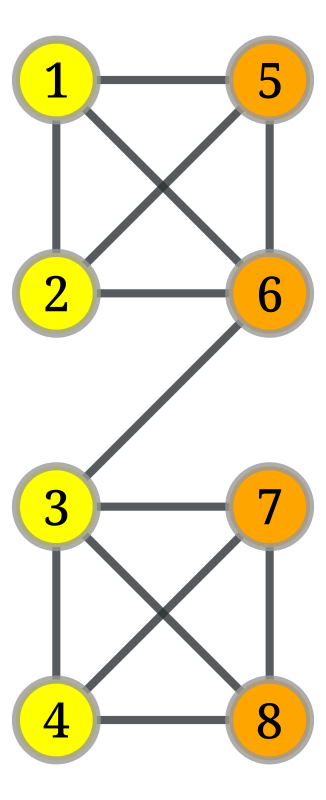

In [ ]:
swap_nodes(max_gain_index[0], max_gain_index[1])


Hier muss man jetzt noch evaluieren wo man den besten gain hatte. Also eigentlich nur nachsehen wo die cut-size am niedrigsten war.

The argument is obviously that no matter which starting arrangement is chosen you will always arrive at the optimal solution since you try out every possibility. The only version i could think of is one that basically lures a first swap that makes the optimal set impossible in the beginning and since these nodes are already locked in the beginning the optimal solution of cut size 1 can never be reached. This could be a possibility that we can look into for finding. But nonetheless it is otherwise very unlikely with this algorithm.

The required solution is exactly what is demonstrated in this [Video](https://www.youtube.com/watch?v=GsMZYDBFJv4&t=1429s)

## Exercise 2 Modularity
(3 points)
* Experiment with modularity optimisation in your favorite software. Calculate
modularity values (e.g., in networkx) for the “non-intuitive” example networks given in the lecture.


**To provide a solution to the exercise:**
Provide the modularity values (a), the best modularity optimising community structure you can find (b) drawing, argument, and the proof(s).


The following four graphs represent the non-intuitive example networks given in the lecture. We define them in `graph_tool` and generate the results for the modularity optimization using the [modularity](https://graph-tool.skewed.de/static/docs/stable/autosummary/graph_tool.inference.modularity.html) method.

In [ ]:
#| export
# Create graph
def create_graph_a() -> Tuple[Graph, VertexPropertyMap]:
    g = Graph(directed=False)
    vlist = [g.add_vertex() for _ in range(5)]

    # Edges (1-based to 0-based)
    edges = [
        (0, 1), (0, 2), (1, 2),
        (1, 3), (2, 3), (3, 4),
        (4, 5)
    ]
    g.add_edge_list([(u, v) for u, v in edges])
    # Labels (1-based)
    labels = g.new_vertex_property("int")
    for i in range(6):
        labels[g.vertex(i)] = i

    # Define your own partitions
    partition = g.new_vertex_property("int")
    partition[g.vertex(0)] = 1
    partition[g.vertex(1)] = 1
    partition[g.vertex(2)] = 1
    partition[g.vertex(3)] = 0
    partition[g.vertex(4)] = 0
    partition[g.vertex(5)] = 0

    # Draw
    graph_draw(g, vertex_fill_color=partition, output_size=(400, 400))
    return g, partition


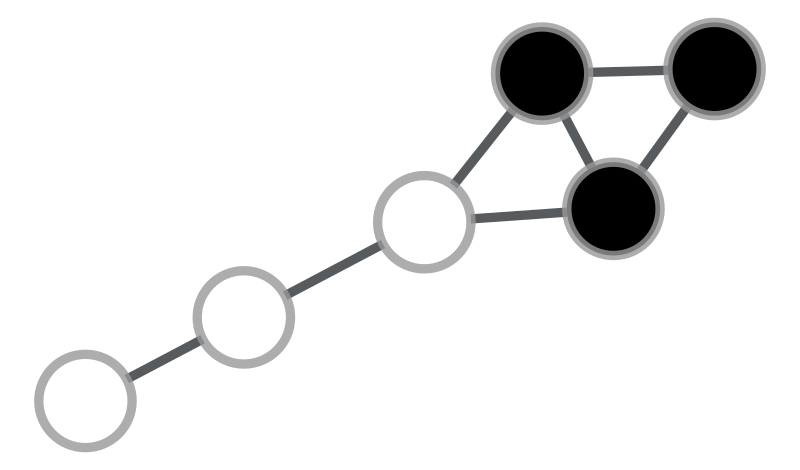

In [ ]:
graphA, partitionA = create_graph_a()

In [ ]:
#| export
# Create graph
def create_graph_b() -> Tuple[Graph, VertexPropertyMap]:
    g = Graph(directed=False)
    vlist = [g.add_vertex() for _ in range(6)]

    # Edges (1-based to 0-based)
    edges = [
        (0, 1), (0, 2), (1, 2),
        (1, 3), (2, 3), (3, 4),
        (4, 5), (6, 0)
    ]
    g.add_edge_list([(u, v) for u, v in edges])
    # Labels (1-based)
    labels = g.new_vertex_property("int")
    for i in range(7):
        labels[g.vertex(i)] = i

    partition = g.new_vertex_property("int")
    partition[g.vertex(0)] = 0
    partition[g.vertex(1)] = 1
    partition[g.vertex(2)] = 1
    partition[g.vertex(3)] = 1
    partition[g.vertex(4)] = 2
    partition[g.vertex(5)] = 2
    partition[g.vertex(6)] = 0


    # Draw
    graph_draw(g, vertex_fill_color=partition, vertex_text=labels, output_size=(400, 400))
    return g, partition


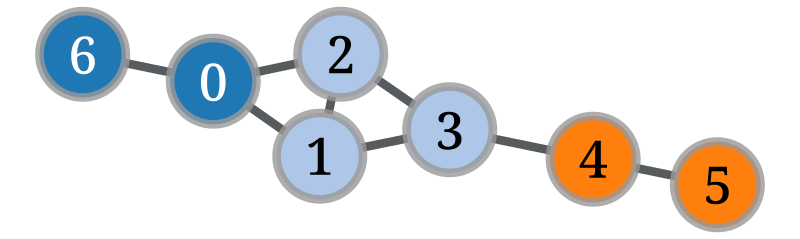

In [ ]:
graphB, partitionB = create_graph_b()

In [ ]:
#| export
# Create graph
def create_graph_c() -> Tuple[Graph, VertexPropertyMap]:
    g = Graph(directed=False)
    vlist = [g.add_vertex() for _ in range(5)]

    # Edges (1-based to 0-based)
    edges = [
        (0, 1), (0, 2), (1, 2),
        (1, 3), (2, 4), (5, 0)
    ]
    g.add_edge_list([(u, v) for u, v in edges])
    # Labels (1-based)
    labels = g.new_vertex_property("int")
    for i in range(6):
        labels[g.vertex(i)] = i


    partition = g.new_vertex_property("int")
    partition[g.vertex(0)] = 0
    partition[g.vertex(1)] = 1
    partition[g.vertex(2)] = 2
    partition[g.vertex(3)] = 1
    partition[g.vertex(4)] = 2
    partition[g.vertex(5)] = 0

    # Draw
    graph_draw(g, vertex_fill_color=partition, vertex_text=labels, output_size=(400, 400))
    return g, partition


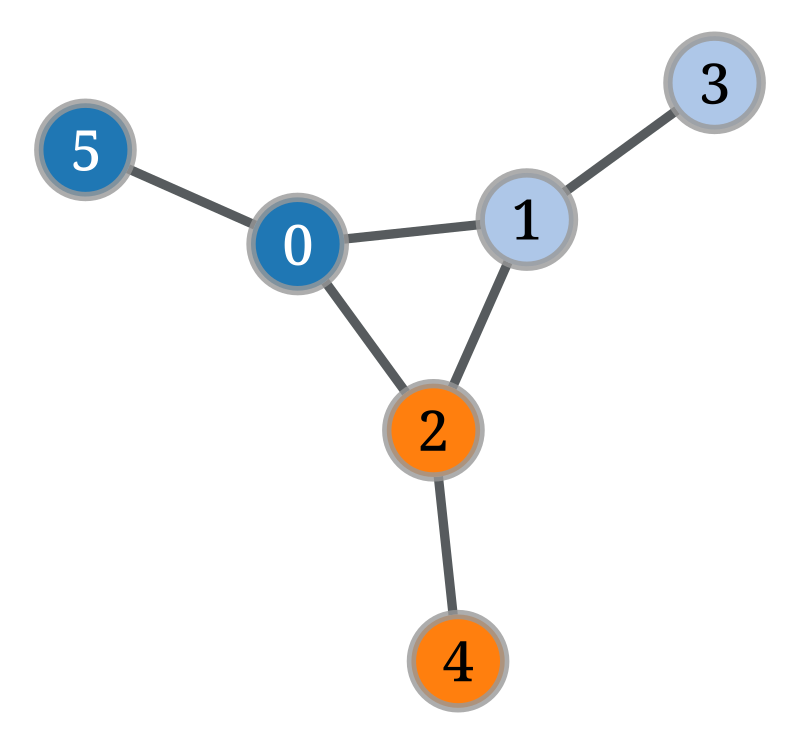

In [ ]:
graphC, partitionC = create_graph_c()

In [ ]:
#| export
# Create graph
def create_graph_d() -> Tuple[Graph, VertexPropertyMap]:
    g = Graph(directed=False)
    vlist = [g.add_vertex() for _ in range(11)]

    # Edges (1-based to 0-based)
    edges = [
        (0, 1), (0, 2), (1, 2),
        (1, 3), (2, 4), (5, 0),
        (6, 7), (6, 8), (7, 8),
        (7, 9), (8, 10), (6, 11)
    ]
    g.add_edge_list([(u, v) for u, v in edges])
    # Labels (1-based)
    labels = g.new_vertex_property("int")
    for i in range(12):
        labels[g.vertex(i)] = i

    partition = g.new_vertex_property("int")
    partition[g.vertex(0)] = 0
    partition[g.vertex(1)] = 0
    partition[g.vertex(2)] = 0
    partition[g.vertex(3)] = 0
    partition[g.vertex(4)] = 0
    partition[g.vertex(5)] = 0

    partition[g.vertex(6)] = 1
    partition[g.vertex(7)] = 1
    partition[g.vertex(8)] = 1
    partition[g.vertex(9)] = 1
    partition[g.vertex(10)] = 1
    partition[g.vertex(11)] = 1


    # Draw
    graph_draw(g, vertex_fill_color=partition, vertex_text=labels, output_size=(400, 400))
    return g, partition

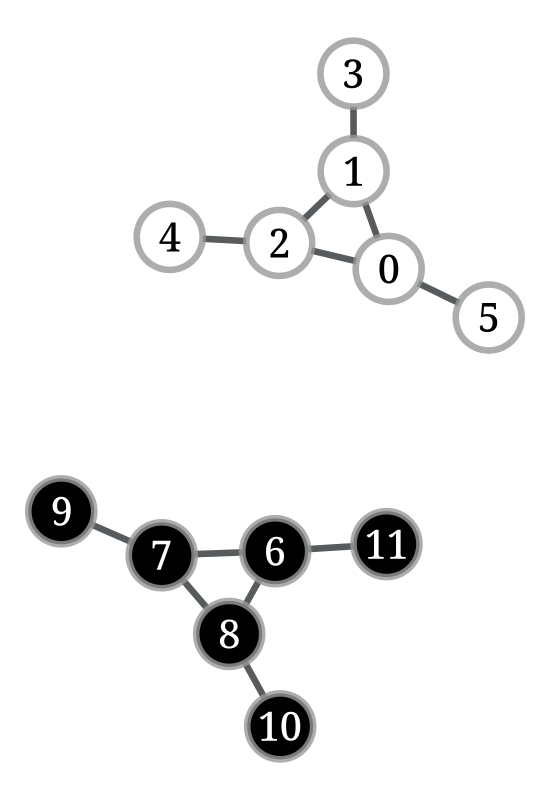

In [ ]:
graphD, partitionD = create_graph_d()

In [ ]:
print(f"Modularity Graph A (Non-local behaviour): {graph_tool.inference.modularity(graphA, partitionA)}")
print(f"Modularity Graph B (Non-local behaviour): {graph_tool.inference.modularity(graphB, partitionB)}")
print(f"Modularity Graph C (a clique K_3 with leaves): {graph_tool.inference.modularity(graphC, partitionC)}")
print(f"Modularity Graph D: (scaling behaviour): {graph_tool.inference.modularity(graphD, partitionD)}")

Modularity Graph A (Non-local behaviour): 0.20408163265306126
Modularity Graph B (Non-local behaviour): 0.2109375
Modularity Graph C (a clique K_3 with leaves): 0.16666666666666666
Modularity Graph D: (scaling behaviour): 0.5


*  Optimise modularity for the following graph consisting of a ring of same-size cliques and neighbouring cliques connected via a single link. Determine the modularity of a clustering in which each clique is its own cluster, and of the clustering where two neighbouring cliques are forming a cluster.


`graph_tool` doesn't provide a [ring_of_cliques](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.ring_of_cliques.html) generator function like networkx, so i define my own.

In [ ]:
# Create graph
def ring_of_cliques(num_cliques=6, clique_size=5) ->Graph:
    if num_cliques < 2:
        raise ValueError("A ring of cliques must have at least two cliques.")
    if clique_size < 2:
        raise ValueError("The cliques must have at least two nodes.")
    g = Graph(directed=False)
    number_of_nodes = num_cliques * clique_size
    vlist = [g.add_vertex() for _ in range(number_of_nodes)]

    for i in range(num_cliques):
        edges = itertools.combinations(range(i * clique_size, i * clique_size + clique_size), 2)
        g.add_edge_list(edges)
        g.add_edge(i * clique_size + 1, (i+1) * clique_size % (num_cliques * clique_size))
    # Labels
    labels = g.new_vertex_property("int")
    for i in range(number_of_nodes):
        labels[g.vertex(i)] = i
    # Draw
    graph_draw(g, vertex_text=labels, output_size=(400, 400))
    return g

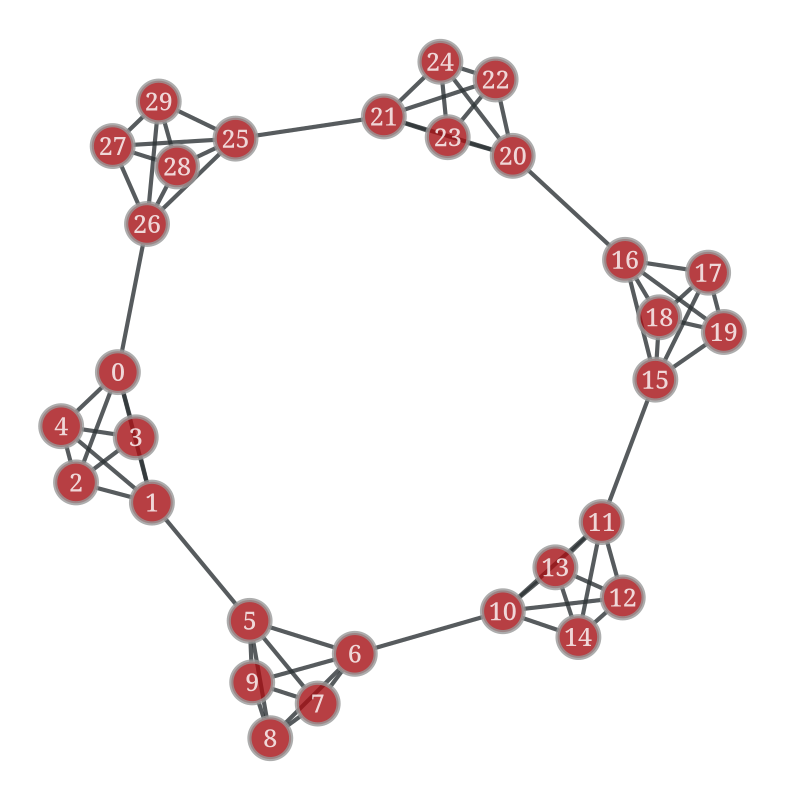

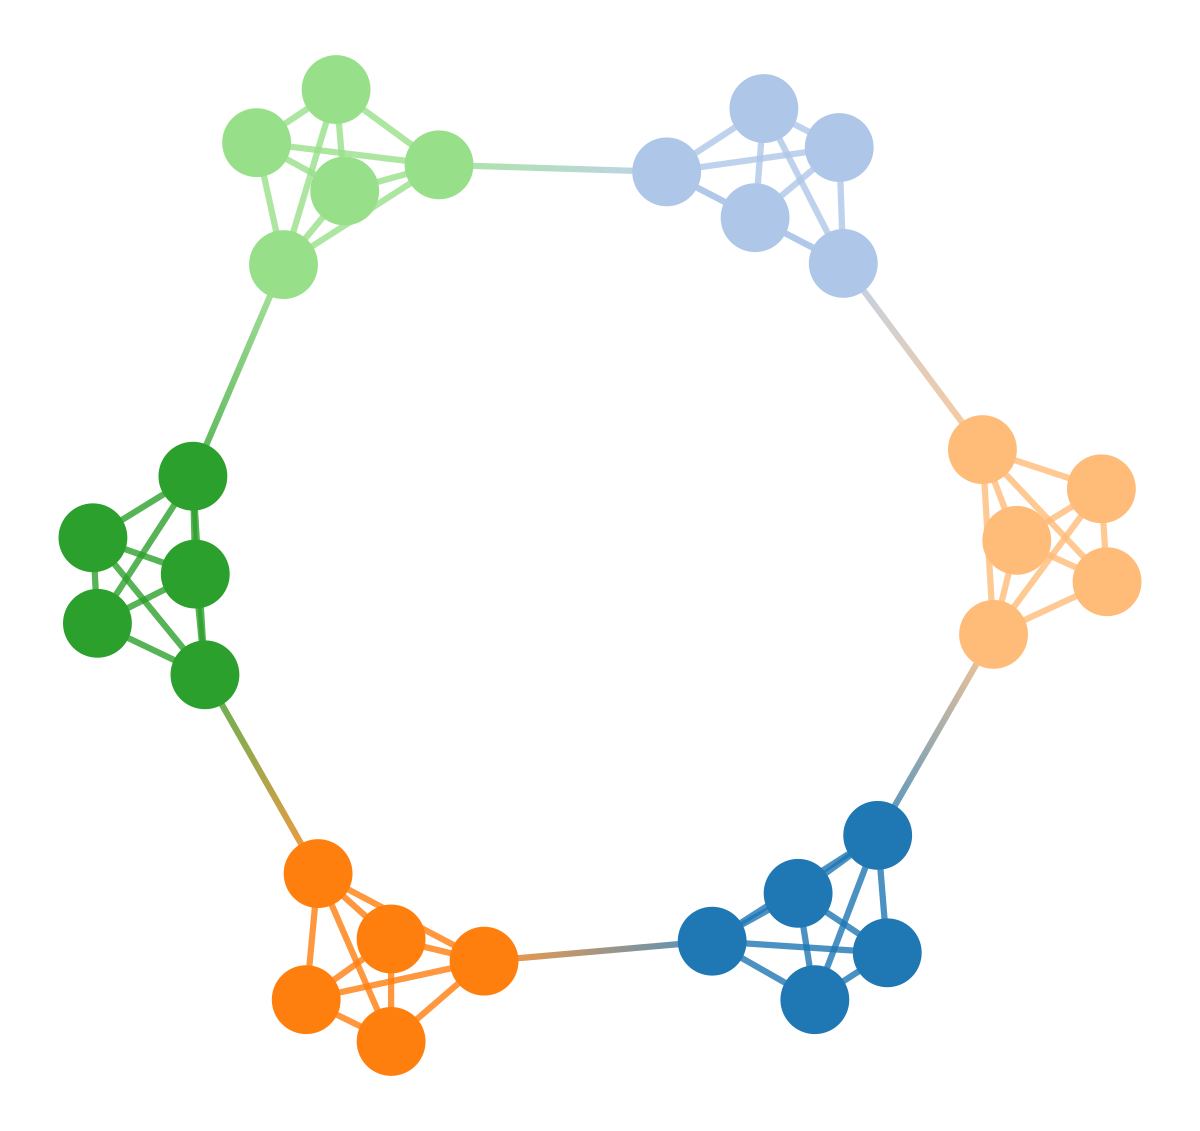

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f20834f3c80,>

In [ ]:
graphClique = ring_of_cliques(num_cliques=6, clique_size=5)
state = minimize_blockmodel_dl(graphClique, state=ModularityState)
state.draw()

In [ ]:
def manual_partition(graph, clique_size, num_cliques, grouping="per_clique"):
    prop = graph.new_vertex_property("int")
    for i in range(num_cliques):
        for j in range(clique_size):
            v = graph.vertex(i * clique_size + j)
            if grouping == "per_clique":
                group = i
            elif grouping == "two_cliques":
                group = i /2
            else:
                raise ValueError("Unknown grouping mode")
            prop[v] = group
    return prop

Modularity (one clique per cluster):  0.7424242424242423
Modularity (one clique per cluster):  0.6212121212121212


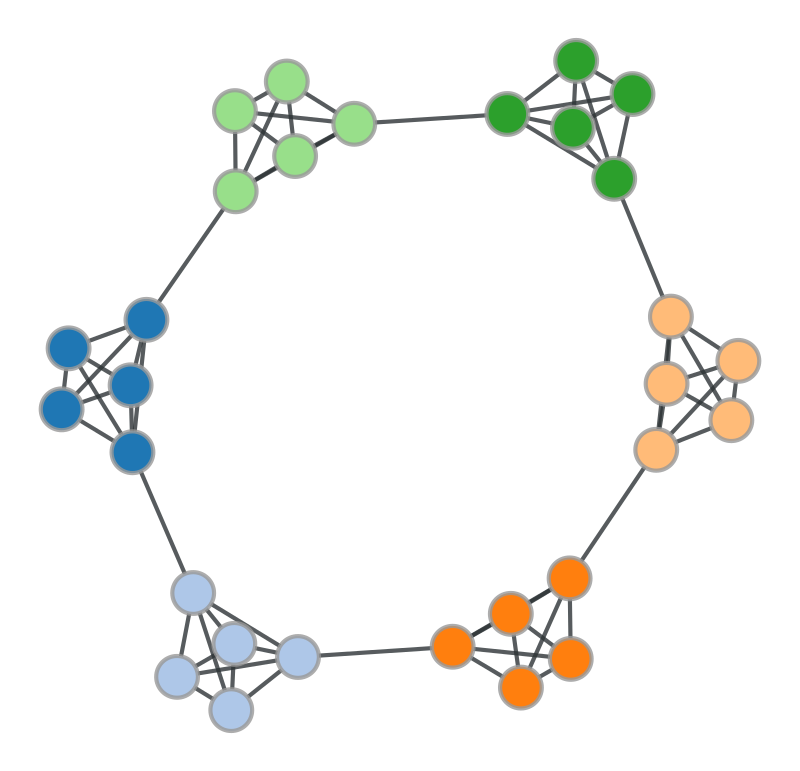

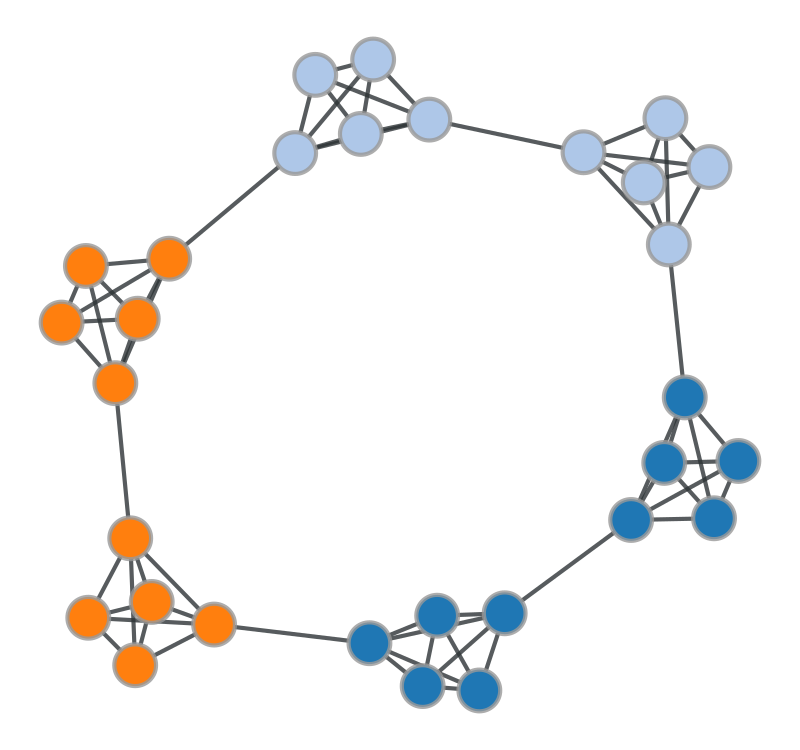

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f208015fad0,>

In [ ]:
partition1 = manual_partition(graphClique, clique_size=5, num_cliques=6, grouping="per_clique")
partition2 = manual_partition(graphClique, clique_size=5, num_cliques=6, grouping="two_cliques")

print("Modularity (one clique per cluster): ", modularity(graphClique, partition1))
print("Modularity (one clique per cluster): ", modularity(graphClique, partition2))

graph_draw(graphClique, vertex_fill_color=partition1, output_size=(400, 400))
graph_draw(graphClique, vertex_fill_color=partition2, output_size=(400, 400))



* Proof that a clustering with optimal modularity has no cluster with a single node of degree 1.

Optimal Modularity is defined as ...

If a single node has degree 1 ...




*  Extra(not mandatory): Given a line graph, a path of N nodes. Show that if we divide the network into two parts by cutting a line, with r and N-r nodes each part, then the modularity is $$\frac{3 − 4𝑛 + 4𝑟𝑛 − 4𝑟^2}{2(𝑛 − 1)^2}$$
Hence show that if N is even, the optimal division for modularity is splitting the graph exactly in the middle.



ring of same sized cliques  and neighboring cliques connected via single link.

* Clustering wiht optimal modularity has no cluster iwht a single node of degree 1
* Gibts in dem graph überhaupt eine node mit degree 1 und wenn ja  ist sie in einer rolle in der sie nicht automatisch teil eines größeren clusters wird?



## Exercise 3
(2 points)
* Consider the following small network
To provide a solution to the exercise:
Calculate for each of the 10 pairs of nodes the cosine similarity. Based on the values,
construct the dendrogram for the single-linkage hierarchical clustering of the network.

Ok the exercise is about hierarchical clustering

Clustering is also part of lecture 7 and comes after community detection. Clustering just has this special goal of having a similarity metric. So you are not just looking for communities based on minimizing the cut size between the communities and basically having this as your similarity metric. But you could have an arbitrary similarity metric that can also have to do with some of the additional data contained in the nodes. So this clustering is also something that is done in normal data analysis where you just have structured data. So graph clustering is like this but with the additional Network structure on top.

Spaltenvektoren nehmen und cosine similarity berechnen.

dendrogram mit scipy oder so zeichen oder manuell mit tikz oder so




## Exercise 4
(3 points) Clustering

Execute partitioning/community detection/clustering on two networks of your chosing (but with more than 100 nodes).

See for example for networkx the documentation on communities to find supported methods, but feel free to use a different tool or framework (note that Leiden and Louvain are implemented).

a) Apply a partitioning / community detection method on your networks.

b) Apply a hierarchical clustering on your networks.

c) Draw the networks with the partitions / communities mapped to visual variables (e.g. color). Report the images and shortly discuss if you think the results can be improved.

d) Draw the dendrogram from the hierarchical clustering and report it.

e) Find a level in the dendrogram that you consider a good clustering. Report it and shortly explain why it is better than the others.

Einfach ein mixed bag of doing stuff auf zwei netzwerken, das klingt ganz gut machbar.


In [ ]:

#| hide
import nbdev;nbdev.nbdev_export()